In [ ]:
library(MASS)
library(fitHeavyTail)
library(xts)
library(quantmod)
library(igraph)
library(readr)
library(spectralGraphTopology)
library(combinat)
library(ggplot2)
library(reshape2)
library(ktvgraph)
library(Matrix)
library(LaplacesDemon)
library(expm)



source("R/utils.R")

options(warn = -1)


In [145]:
set.seed(42)


pdf(file = "Plots_TVGL_results.pdf")


# number of stocks
r <- 100 

# number of sectors
q <- 8


# load SP500 stock prices_test into an xts table
stock_prices_orig <- readRDS("examples/stocks/sp500-data-2016-2020.rds")
stock_prices <- stock_prices_orig[1:1001,1:r]

winLen <-  200
Nday <- nrow(stock_prices) 

Nwin <- Nday%/% winLen  





# total nodes in the graph
colnames(stock_prices)[1:r]
#>   [1] "A"    "AAL"  "ABBV" "ABC"  "ABMD" "ABT"  "ADM"  "AEE"  "AEP"  "AES"
#>  [11] "AFL"  "AIG"  "AIV"  "AIZ"  "AJG"  "ALB"  "ALGN" "ALK"  "ALL"  "ALLE"
#>  [21] "ALXN" "AMCR" "AME"  "AMGN" "AMP"  "AMT"  "ANTM" "AON"  "AOS"  "APA"
#>  [31] "APD"  "ARE"  "ATO"  "AVB"  "AVY"  "AWK"  "AXP"  "BA"   "BAC"  "BAX"
#>  [41] "BDX"  "BEN"  "BIIB" "BIO"  "BK"   "BKR"  "BLK"  "BLL"  "BMY"  "BSX"
#>  [51] "BXP"  "C"    "CAG"  "CAH"  "CAT"  "CB"   "CBOE" "CBRE" "CCI"  "CE"
#>  [61] "CERN" "CF"   "CFG"  "CHD"  "CHRW" "CI"   "CINF" "CL"   "CLX"  "CMA"
#>  [71] "CME"  "CMI"  "CMS"  "CNC"  "CNP"  "COF"  "COG"  "COO"  "COP"  "COST"
#>  [81] "COTY" "CPB"  "CPRT" "CSX"  "CTAS" "CVS"  "CVX"  "D"    "DAL"  "DD"
#>  [91] "DE"   "DFS"  "DGX"  "DHR"  "DLR"  "DOV"  "DRE"  "DTE"  "DUK"  "DVA"


# compute log-returns
log_returns <- diff(log(stock_prices), na.pad = FALSE)





# # build network
SP500 <- read_csv("examples/stocks/SP500-sectors.csv")
stock_sectors <- SP500$GICS.Sector[SP500$Symbol %in% colnames(stock_prices)[1:r]]
stock_sectors_return <- as.numeric(as.factor(stock_sectors))


class(log_returns) 

[1] "A"    "AAL"  "ABBV" "ABC"  "ABMD" "ABT"  "ADM"  "AEE"  "AEP"  "AES" 
 [11] "AFL"  "AIG"  "AIV"  "AIZ"  "AJG"  "ALB"  "ALGN" "ALK"  "ALL"  "ALLE"
 [21] "ALXN" "AMCR" "AME"  "AMGN" "AMP"  "AMT"  "ANTM" "AON"  "AOS"  "APA" 
 [31] "APD"  "ARE"  "ATO"  "AVB"  "AVY"  "AWK"  "AXP"  "BA"   "BAC"  "BAX" 
 [41] "BDX"  "BEN"  "BIIB" "BIO"  "BK"   "BKR"  "BLK"  "BLL"  "BMY"  "BSX" 
 [51] "BXP"  "C"    "CAG"  "CAH"  "CAT"  "CB"   "CBOE" "CBRE" "CCI"  "CE"  
 [61] "CERN" "CF"   "CFG"  "CHD"  "CHRW" "CI"   "CINF" "CL"   "CLX"  "CMA" 
 [71] "CME"  "CMI"  "CMS"  "CNC"  "CNP"  "COF"  "COG"  "COO"  "COP"  "COST"
 [81] "COTY" "CPB"  "CPRT" "CSX"  "CTAS" "CVS"  "CVX"  "D"    "DAL"  "DD"  
 [91] "DE"   "DFS"  "DGX"  "DHR"  "DLR"  "DOV"  "DRE"  "DTE"  "DUK"  "DVA"

New names:
• `` -> `...1`
Rows: 505 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Symbol, GICS.Sector
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "xts" "zoo"

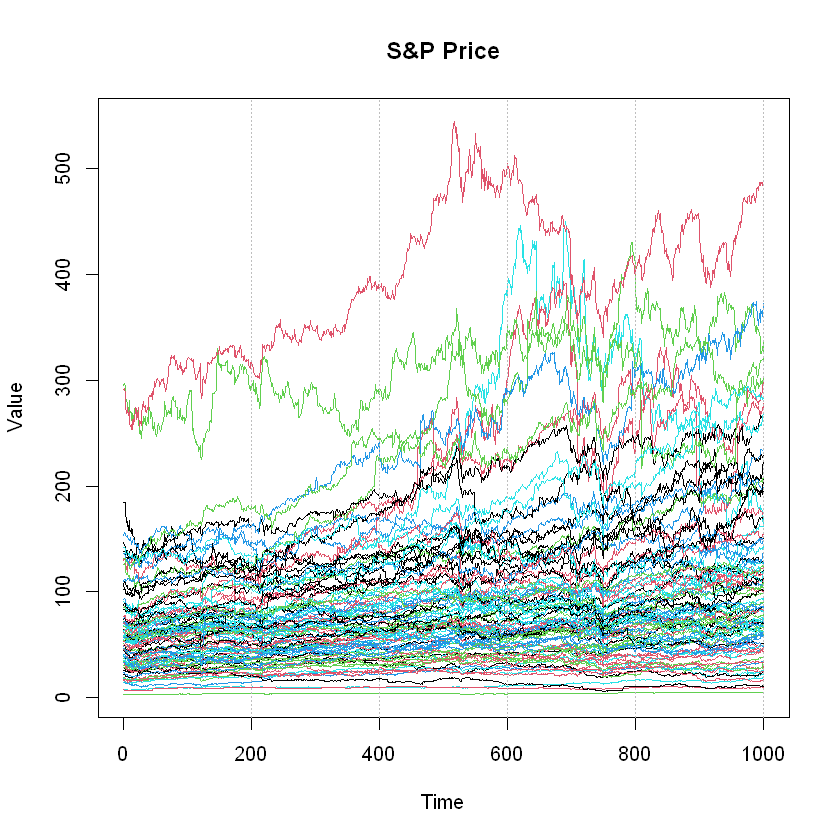

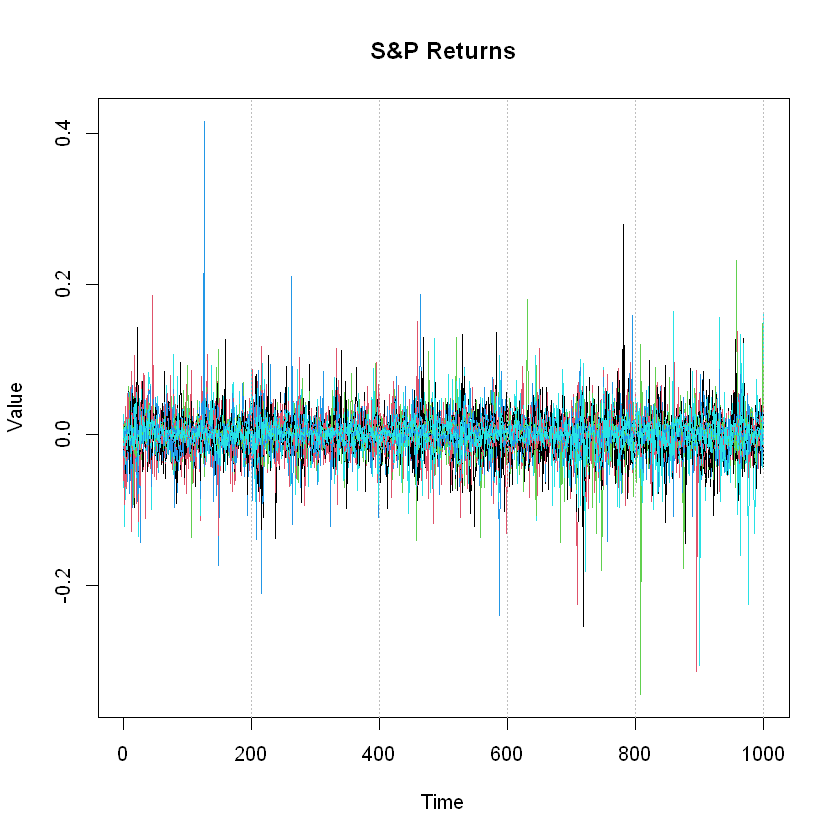

In [106]:
# Step 4: Plot
matplot(stock_prices, type = "l", lty = 1, col = 1:p,
        main = "S&P Price",
        xlab = "Time", ylab = "Value")
abline(v = seq(block_size, n, by = block_size), lty = 3, col = "gray")


# Step 4: Plot
matplot(log_returns, type = "l", lty = 1, col = 1:p,
        main = "S&P Returns",
        xlab = "Time", ylab = "Value")
abline(v = seq(block_size, n, by = block_size), lty = 3, col = "gray")

Matrix 1 | PSD: TRUE | Symmetric: TRUE
Matrix 2 | PSD: TRUE | Symmetric: TRUE
Matrix 3 | PSD: TRUE | Symmetric: TRUE
Matrix 4 | PSD: TRUE | Symmetric: TRUE
Matrix 5 | PSD: TRUE | Symmetric: TRUE


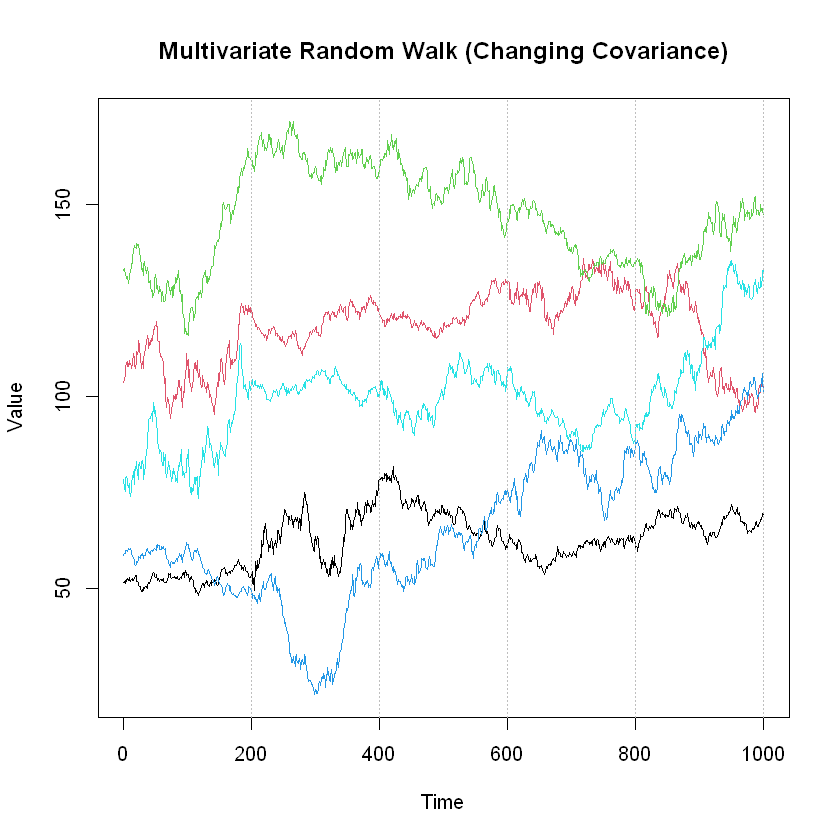

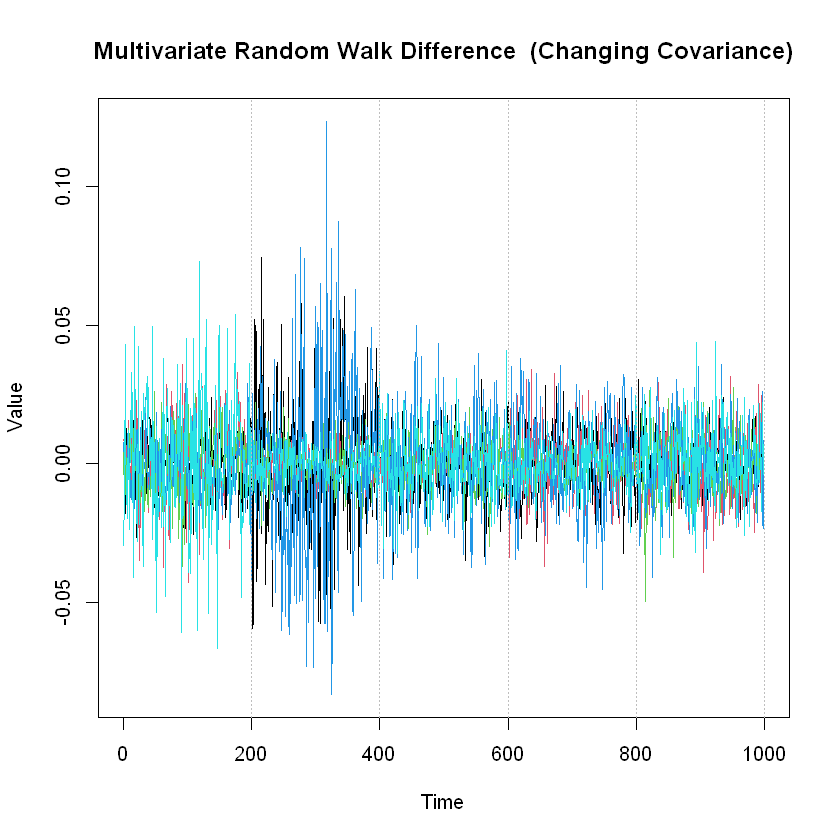

In [220]:
n <- 1000          # total time steps
p <- 5           # number of variables
n_matrices <- 5    # number of covariance regimes
block_size <- n / n_matrices  # 200 in this case

# Step 1: Create 5 covariance matrices
Sigma_list <- vector("list", length = n_matrices)

for (i in 1:n_matrices) {
  std_devs <- runif(p, min = 0.5, max = 2)
  R <- matrix(0, nrow = p, ncol = p)
  R[upper.tri(R)] <- runif(sum(upper.tri(R)), min = -0.5, max = 0.5)
  R <- R + t(R)
  R <- as.matrix(nearPD(R, corr = TRUE)$mat)
  D <- diag(std_devs)
  Sigma <- D %*% R %*% D
  Sigma_list[[i]] <- Sigma

  # Optional: Print check
  cat(sprintf("Matrix %d | PSD: %s | Symmetric: %s\n",
              i,
              all(eigen(Sigma)$values > 0),
              isSymmetric(Sigma)))
}

# Step 2: Generate noise in blocks with changing covariance
epsilon <- matrix(0, nrow = n, ncol = p)

for (i in 1:n_matrices) {
  start_idx <- (i - 1) * block_size + 1
  end_idx <- i * block_size
  epsilon[start_idx:end_idx, ] <- mvrnorm(
    n = block_size,
    mu = rep(0, p),
    Sigma = Sigma_list[[i]]
  )
}

start_price <- runif(p, min = 50, max = 150)
rw_price <- matrix(0, nrow = n, ncol = p)  # <- Add this to fix the error
# Initialize first row
rw_price[1, ] <- pmax(0, epsilon[1, ] + start_price)

# Step through each time step
for (t in 2:n) {
  rw_price[t, ] <- pmax(0, rw_price[t - 1, ] + epsilon[t, ])
}
  
log_rw_returns <- diff(log(rw_price), na.pad = FALSE)

# Step 4: Plot
matplot(rw_price, type = "l", lty = 1, col = 1:p,
        main = "Multivariate Random Walk (Changing Covariance)",
        xlab = "Time", ylab = "Value")
abline(v = seq(block_size, n, by = block_size), lty = 3, col = "gray")


# Step 4: Plot
matplot(log_rw_returns, type = "l", lty = 1, col = 1:p,
        main = "Multivariate Random Walk Difference  (Changing Covariance)",
        xlab = "Time", ylab = "Value")
abline(v = seq(block_size, n, by = block_size), lty = 3, col = "gray")




In [231]:
library(Matrix)
library(MASS)
library(igraph)

n <- 1000          # total time steps
p <- 5             # number of variables
n_matrices <- 5    # number of covariance regimes
block_size <- n / n_matrices  # 200 in this case

# Step 1: Create 5 Laplacian precision matrices
Precision_list <- vector("list", length = n_matrices)

for (i in 1:n_matrices) {
  # Create random symmetric adjacency matrix
  A <- matrix(0, p, p)
  A[upper.tri(A)] <- sample(c(0, 1), size = sum(upper.tri(A)), replace = TRUE, prob = c(0.5, 0.5))
  A <- A + t(A)  # Make symmetric

  # Assign random weights
  A <- A * matrix(runif(p * p, min = 0.1, max = 1), p, p)
  diag(A) <- 0  # zero diagonal

  D <- diag(rowSums(A))          # Degree matrix
  L <- D - A                     # Laplacian = D - A
  L <- L + diag(1, p)  # Ensures positive definiteness

  # Ensure positive definiteness (e.g., add small jitter to diagonal)
  L <- L + diag(1e-3, p)

  Precision_list[[i]] <- L

  cat(sprintf("Matrix %d | PD: %s | Symmetric: %s\n",
              i,
              all(eigen(L)$values > 0),
              isSymmetric(L)))
}

# Step 2: Generate noise in blocks with changing precision (use inverse as covariance)
epsilon <- matrix(0, nrow = n, ncol = p)

for (i in 1:n_matrices) {
  start_idx <- (i - 1) * block_size + 1
  end_idx <- i * block_size
  cov_mat <- solve(Precision_list[[i]])  # Covariance = inverse(precision)

  epsilon[start_idx:end_idx, ] <- mvrnorm(
    n = block_size,
    mu = rep(0, p),
    Sigma = cov_mat
  )
}

# Step 3: Simulate non-negative prices
start_price <- runif(p, min = 50, max = 150)
rw_price <- matrix(0, nrow = n, ncol = p)
rw_price[1, ] <- pmax(0, epsilon[1, ] + start_price)

for (t in 2:n) {
  rw_price[t, ] <- pmax(0, rw_price[t - 1, ] + epsilon[t, ])
}

log_rw_returns <- diff(log(rw_price), na.pad = FALSE)

# Step 4: Plot random walk
matplot(rw_price, type = "l", lty = 1, col = 1:p,
        main = "Multivariate Random Walk (Laplacian Precision)",
        xlab = "Time", ylab = "Value")
abline(v = seq(block_size, n, by = block_size), lty = 3, col = "gray")

# Step 5: Plot log returns
matplot(log_rw_returns, type = "l", lty = 1, col = 1:p,
        main = "Log Returns (Laplacian Precision)",
        xlab = "Time", ylab = "Value")
abline(v = seq(block_size, n, by = block_size), lty = 3, col = "gray")


Matrix 1 | PD: TRUE | Symmetric: FALSE
Matrix 2 | PD: TRUE | Symmetric: FALSE


ERROR: Error in eigen(L)$values > 0: invalid comparison with complex values


Adjacency matrix A:
     [,1] [,2] [,3] [,4] [,5]
[1,]    0    0    0    1    0
[2,]    0    0    1    1    0
[3,]    0    1    0    0    0
[4,]    1    1    0    0    1
[5,]    0    0    0    1    0
Laplacian matrix L:
     [,1] [,2] [,3] [,4] [,5]
[1,]    1    0    0   -1    0
[2,]    0    2   -1   -1    0
[3,]    0   -1    1    0    0
[4,]   -1   -1    0    3   -1
[5,]    0    0    0   -1    1


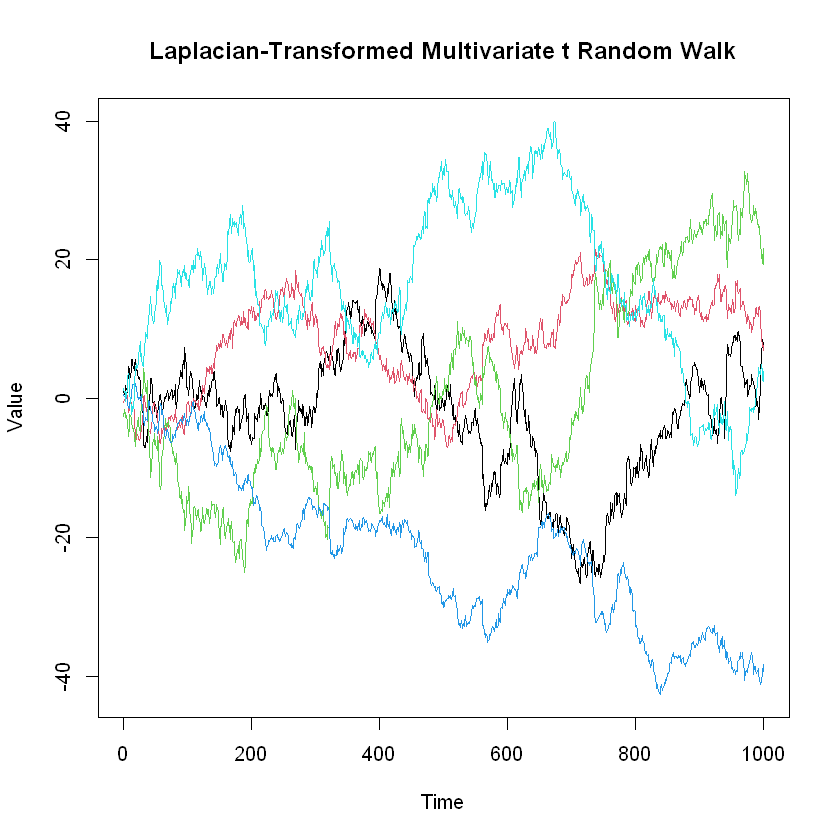

In [327]:
library(MASS)     # for ginv and rmvt
library(expm)     # for sqrtm
library(igraph)   # for is.connected



n <- 1000   # number of observations
p <- 5      # number of nodes

# Step 1: Create connected graph and Laplacian
repeat {
  A <- matrix(0, p, p)
  A[upper.tri(A)] <- sample(c(0, 1), size = sum(upper.tri(A)), replace = TRUE, prob = c(0.6, 0.4))
  A <- A + t(A)
  diag(A) <- 0

  g <- igraph::graph_from_adjacency_matrix(A, mode = "undirected")
  if (is.connected(g)) break  # Ensure connectivity
}

D <- diag(rowSums(A))
L <- D - A

cat("Adjacency matrix A:\n")
print(A)
cat("Laplacian matrix L:\n")
print(L)

# Step 2: Sample from multivariate Student's t-distribution
mu <- rep(0, p)

Identity = TRUE

if(Identity == TRUE){
    Sigma <- diag(p)
} else{
    # 1. Generate random standard deviations (diagonal entries)
    std_devs <- runif(p, min = 0.5, max = 2)
    D <- diag(std_devs)

    # 2. Create a random symmetric correlation matrix
    R <- matrix(0, nrow = p, ncol = p)
    R[upper.tri(R)] <- runif(sum(upper.tri(R)), min = -0.5, max = 0.5)
    R <- R + t(R)
    diag(R) <- 1

    # 3. Project to nearest valid correlation matrix (positive semi-definite)
    R <- as.matrix(nearPD(R, corr = TRUE)$mat)

    # 4. Construct the covariance matrix: Σ = D * R * D
    Sigma <- D %*% R %*% D
    Sigma  <- (Sigma  + t(Sigma)) / 2  # Force symmetry
}

df <- 5
nu_t <- rmvt(n = n, mu = mu, S = Sigma, df = df)

# Step 3: Pseudo-inverse sqrt of Laplacian (with regularization)
epsilon <- 1e-5
L_pinv <- MASS::ginv(L)  # regularized
L_pinv_sqrt <- sqrtm(L_pinv)

# Step 4: Transform the samples
x_t <- nu_t %*% t(L_pinv_sqrt)  # shape: n x p

# Step 5: Cumulative sum to simulate random walk
rw_t <- apply(x_t, 2, cumsum)

# Optional: Plot one variable
matplot(rw_t, type = "l", lty = 1, col = 1:p,
        main = "Laplacian-Transformed Multivariate t Random Walk",
        xlab = "Time", ylab = "Value")


In [324]:
L_pinv_sqrt

63.78986,63.19770,63.01062,63.14683,63.08275
63.19770,63.81111,62.95975,63.06149,63.19770
63.01062,62.95975,64.04907,63.19770,63.01062
63.14683,63.06149,63.19770,63.67490,63.14683
63.08275,63.19770,63.01062,63.14683,63.78986


In [227]:
winLen <-  200
Nday <- nrow(log_rw_returns) 
Nwin <- Nday%/% winLen  

q = 1


#----------------------------
## Online TV graph learning (proposed)
forget_fac <- 0.1
#data_frame <- log_returns[1:winLen,]
data_frame <- log_rw_returns[1:winLen,]

S_cov <- cor(scale(data_frame))
w <- spectralGraphTopology:::w_init('naive', MASS::ginv(S_cov))
w0 <- w
A0 <- A(w)
A0 <- A0 / rowSums(A0)
w0 <- spectralGraphTopology:::Ainv(A0)
w0 = w0/sum(w0)

w_lagged <- w0

w_lagged <- 0

graphs_list <- vector("list", Nwin)

components_graph <- vector("list", Nwin)

accuracy_vec <- rep(0,Nwin)
accuracy_adj_vec <- rep(0,Nwin)
purity_vec <- rep(0,Nwin)
mod_g_vec <- rep(0,Nwin)
mod_gt_vec <- rep(0,Nwin)
balanced_vec <- rep(0,Nwin)
balanced_norm_vec <- rep(0,Nwin)
GINI_vec <- rep(0,Nwin)
rank_mat <- rep(0,Nwin)

#cat("init w: ",w,"\n")
#cat("init w_lagged: ", w_lagged,"\n")
#cat("init w0: ",w0,"\n")

Cluster = FALSE

# heavy_type = "gaussian"
# heavy_type = "student"

for (i in 1:Nwin){
  #print("============")
  #cat("Loop: ",i, "\n")
 
  #data_frame <- log_returns[((i-1)*winLen+1):(i*winLen),]
  data_frame <- log_rw_returns[((i-1)*winLen+1):(i*winLen),]
  nu <- fit_mvt(data_frame, nu = "MLE-diag-resampled")$nu #Estimate parameters of a multivariate Student's t
  #cat("nu: ",nu,"\n")
  #graphs_list[[i]] <- learn_kcomp_heavytail_TV_graph_online(scale(data_frame),
  #                                                   k = q, # k the number of components of the graph. (Number of Clusters)
  #                                                   heavy_type = "gaussian", # the statistical distribution of the data "gaussian" or "student".
  #                                                   nu = nu, # the degrees of freedom of the Student-t distribution. Must be a real number greater than 2.
  #                                                   sigma_e = exp(10), # hyperparameter that controls graph weight sparsity and time-consistency
  #                                                   w_lagged = w_lagged,
  #                                                   rho = 2, # ADMM hyperparameter.
  #                                                   d = 1, # the nodes' degrees. Either a vector or a single value.
  #                                                   w0 = w0, # initial value of the VAR coefficient
  #                                                   update_eta = TRUE, # whether to update eta during the optimization.
  #                                                   maxiter = 100,
  #                                                   verbose = TRUE)
  
  graphs_list[[i]] <- learn_kcomp_heavytail_graph(scale(data_frame), k = q, heavy_type = "gaussian",
                                                             nu = nu,
                                                             beta = 1e-8,
                                                             rho = 1,
                                                             d = 1,
                                                             w0 = w0,
                                                             update_beta = TRUE,
                                                             maxiter = 10000,
                                                             reltol = 1e-5,
                                                             verbose = TRUE)

  
  w <-  spectralGraphTopology:::Ainv(graphs_list[[i]]$adjacency)
  w_lagged <- w
  w0 <- w
  #cat("w: ",w,"\n")
  #cat(" w_lagged: ", w_lagged,"\n")
  #cat("w0: ",w0,"\n")
 

  if(Cluster== TRUE){
    net_Fin <- graph_from_adjacency_matrix(graphs_list[[i]]$adjacency,
                                            mode = "undirected",
                                            weighted = TRUE)
  


    # where do predictions differ from GICS?
    metric <- evaluate_clustering(net_Fin, stock_sectors_return, r, q)
    

    components_graph[[i]] <- metric$labels_pred

    accuracy_adj_vec[i] <- metric$accuracy_adj
    purity_vec[i] <- metric$purity
    mod_g_vec[i] <- metric$mod_g
    mod_gt_vec[i] <- metric$mod_gt
    balanced_vec[i] <- metric$balanced
    balanced_norm_vec[i] <- metric$balanced_norm
    GINI_vec[i] <- metric$GINI

    rank_mat[i] <- rankMatrix(graphs_list[[i]]$laplacian)[1]
  }

}

In [228]:
i = 2

L = graphs_list[[i]]$laplacian
Sigma = Sigma_list[[i]]

print(Sigma)


print("Target Precision")
print(MASS::ginv(Sigma))

print("L")
print(L)

           [,1]       [,2]        [,3]        [,4]       [,5]
[1,]  2.5721481 -0.5076224  0.46180138  0.39950234 -0.1079802
[2,] -0.5076224  0.7021500  0.27597461 -0.32507848  0.2293297
[3,]  0.4618014  0.2759746  1.82610502 -0.01330166 -0.2292705
[4,]  0.3995023 -0.3250785 -0.01330166  1.73157221 -0.2699732
[5,] -0.1079802  0.2293297 -0.22927047 -0.26997321  0.4605846
[1] "Target Precision"
            [,1]       [,2]        [,3]        [,4]       [,5]
[1,]  0.54822692  0.5779659 -0.26861848 -0.07232981 -0.3353576
[2,]  0.57796592  2.6785741 -0.73677923  0.13192079 -1.4876190
[3,] -0.26861848 -0.7367792  0.81993382  0.04508668  0.7384500
[4,] -0.07232981  0.1319208  0.04508668  0.67127088  0.3332692
[5,] -0.33535756 -1.4876190  0.73845000  0.33326915  3.3961659
[1] "L"
           [,1]       [,2]       [,3]       [,4]       [,5]
[1,]  0.9999868  0.0000000 -0.4074005 -0.3823213 -0.2102650
[2,]  0.0000000  0.9999905 -0.3510353 -0.1176547 -0.5313004
[3,] -0.4074005 -0.3510353  1.0000146 -

In [181]:
adjacency <- graphs_list[[Nwin]]$adjacency

names(graphs_list[[Nwin]])

[1] "laplacian"           "adjacency"           "weights"            
 [4] "theta"               "maxiter"             "convergence"        
 [7] "eta_seq"             "primal_lap_residual" "primal_deg_residual"
[10] "dual_residual"       "lagrangian"          "elapsed_time"

In [229]:
graphs_list[[i]]

0.9999868,0.0000000,-0.4074005,-0.3823213,-0.2102650
0.0000000,0.9999905,-0.3510353,-0.1176547,-0.5313004
-0.4074005,-0.3510353,1.0000146,-0.2415788,0.0000000
-0.3823213,-0.1176547,-0.2415788,1.0000034,-0.2584486
-0.2102650,-0.5313004,0.0000000,-0.2584486,1.0000141
0.0000000,0.0000000,0.4074005,0.3823213,0.2102650
0.0000000,0.0000000,0.3510353,0.1176547,0.5313004
0.4074005,0.3510353,0.0000000,0.2415788,0.0000000
0.3823213,0.1176547,0.2415788,0.0000000,0.2584486
0.2102650,0.5313004,0.0000000,0.2584486,0.0000000
9.999923e-01,-4.035165e-06,-4.074000e-01,-0.3823187,-2.102696e-01


In [ ]:
for (j in 1:Nwin) {
  
  adjacency <- graphs_list[[j]]$adjacency
  net_Fin <- graph_from_adjacency_matrix(adjacency, mode = "undirected", weighted = TRUE)
  
  
  # where do our predictions differ from GICS?
  metric <- evaluate_clustering(net_Fin, stock_sectors_return, r, q) 
  labels_pred_adj <-  metric$labels_pred_adj
  
  
  
  colors <- c("#55efc4", "#ff7675", "#0984e3", "#a29bfe", "#B33771", "#48dbfb", "#FDA7DF", "#C4E538")
  
  
  
  
  # ground truth coloring 
  V(net_Fin)$color <- c(colors[stock_sectors_return])
  V(net_Fin)$type <- c(rep(FALSE, r))
  V(net_Fin)$cluster <- c(stock_sectors_return)
  E(net_Fin)$color <- apply(
    as.data.frame(get.edgelist(net_Fin)), 1,
    function(x) {
      ifelse(V(net_Fin)$cluster[x[1]] == V(net_Fin)$cluster[x[2]],
             colors[V(net_Fin)$cluster[x[1]]], "grey"
      )
    }
  )
  
  mask <- labels_pred_adj != stock_sectors_return
  node_labels <- colnames(stock_prices)[1:r]
  node_labels[!mask] <- NA
  label_colors <- rep("black",r)

  
  # plot network
  plot(net_Fin,
       vertex.size = c(rep(4, r)),
       vertex.label = c(node_labels),
       vertex.label.color = label_colors,
       vertex.label.cex = 0.8, vertex.label.dist = 0.5,
       vertex.frame.color = c(colors[stock_sectors_return]),
       layout = layout_nicely(net_Fin),
       vertex.label.family = "Helvetica", vertex.label.color = "black",
       vertex.shape = c(rep("circle", r)),
       edge.width = 3 * E(net_Fin)$weight
  )
  
  
  # implied clusters
  stock_sectors_return_res <- stock_sectors_return
  stock_sectors_return <- igraph::components(net_Fin)$membership
  V(net_Fin)$color <- c(colors[stock_sectors_return])
  V(net_Fin)$type <- c(rep(FALSE, r))
  V(net_Fin)$cluster <- c(stock_sectors_return)
  E(net_Fin)$color <- apply(
    as.data.frame(get.edgelist(net_Fin)), 1,
    function(x) {
      ifelse(V(net_Fin)$cluster[x[1]] == V(net_Fin)$cluster[x[2]],
             colors[V(net_Fin)$cluster[x[1]]], "grey"
      )
    }
  )
  
  
  node_labels <- colnames(stock_prices)[1:r]
  # plot network
  plot(net_Fin,
       vertex.size = c(rep(4, r)),
       vertex.label = c(node_labels),
       vertex.label.cex = 0.8, vertex.label.dist = 0.5,
       vertex.frame.color = c(colors[stock_sectors_return]),
       layout = layout_nicely(net_Fin),
       vertex.label.family = "Helvetica", vertex.label.color = "black",
       vertex.shape = c(rep("circle", r)),
       edge.width = 3 * E(net_Fin)$weight
  )
  
  
  stock_sectors_return <- stock_sectors_return_res
  
}

In [ ]:
print(metric$accuracy)
print(metric$accuracy_adj)
print(metric$purity)
print(metric$mod_g)
print(metric$mod_gt)
print(metric$balanced)
print(metric$balanced_norm)
print(metric$GINI)


metrics <- matrix(rep(0,4*Nwin), Nwin, 4)
metrics[,1] <- accuracy_adj_vec
metrics[,2] <- purity_vec
metrics[,3] <- mod_gt_vec
metrics[,4] <- balanced_norm_vec

matplot(metrics, type = "b",pch=2,col = 1:4, ylab = "Metrics")
names <- c("Accuracy", "Purity", "Modularity", "Balancedness")
legend("bottomleft", inset=0.01, legend=names, col=c(1:4),pch=15:18,
       bg= ("white"), horiz=F)




dev.off()

In [ ]:
plot_stock_network <- function(net, stock_labels, colors, title = "") {
  layout <- layout_nicely(net)
  node_labels <- colnames(stock_prices)[1:r]
  
  plot(
    net,
    main = title,
    layout = layout,
    vertex.size = 5,
    vertex.label = node_labels,
    vertex.label.cex = 0.7,
    vertex.label.color = "black",
    vertex.label.family = "Helvetica",
    vertex.frame.color = colors[stock_labels],
    vertex.color = colors[stock_labels],
    edge.width = 2 + 2 * E(net)$weight,
    edge.color = E(net)$color,
    vertex.shape = "circle",
    margin = 0.2
  )
}


In [ ]:
colors <- c("#55efc4", "#ff7675", "#0984e3", "#a29bfe", "#B33771", "#48dbfb", "#FDA7DF", "#C4E538")

for (j in 1:Nwin) {
  adjacency <- graphs_list[[j]]$adjacency
  net_Fin <- graph_from_adjacency_matrix(adjacency, mode = "undirected", weighted = TRUE)

  metric <- evaluate_clustering(net_Fin, stock_sectors_return, r, q) 
  labels_pred_adj <- metric$labels_pred_adj

  ## -- GICS Ground Truth --
  V(net_Fin)$cluster <- stock_sectors_return
  V(net_Fin)$color <- colors[stock_sectors_return]
  E(net_Fin)$color <- apply(
    as.data.frame(get.edgelist(net_Fin)), 1,
    function(x) {
      ifelse(
        V(net_Fin)$cluster[as.numeric(x[1])] == V(net_Fin)$cluster[as.numeric(x[2])],
        colors[V(net_Fin)$cluster[as.numeric(x[1])]],
        "grey"
      )
    }
  )

  plot_stock_network(net_Fin, stock_sectors_return, colors, title = paste("Ground Truth - Window", j))

  ## -- Predicted Clusters --
  stock_sectors_pred <- igraph::components(net_Fin)$membership
  V(net_Fin)$cluster <- stock_sectors_pred
  V(net_Fin)$color <- colors[stock_sectors_pred]
  E(net_Fin)$color <- apply(
    as.data.frame(get.edgelist(net_Fin)), 1,
    function(x) {
      ifelse(
        V(net_Fin)$cluster[as.numeric(x[1])] == V(net_Fin)$cluster[as.numeric(x[2])],
        colors[V(net_Fin)$cluster[as.numeric(x[1])]],
        "grey"
      )
    }
  )

  plot_stock_network(net_Fin, stock_sectors_pred, colors, title = paste("Predicted Clusters - Window", j))
}
